In [1]:
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import load_svmlight_file
from sklearn.datasets import make_classification, make_regression
from scipy.stats import spearmanr
from xgboost import XGBClassifier, XGBRegressor

# import the path of the project
sys.path.append(os.path.abspath("src"))

from preprocess.FeatureSplitter import CorrelationSplitter, ImportanceSplitter
from preprocess.FeatureEvaluator import CorrelationEvaluator, ImportanceEvaluator
from dataset.WideDataset import WideDataset
from dataset.SatelliteDataset import SatelliteDataset

#auto reload modules
%load_ext autoreload
%autoreload 2

In [2]:
# Summarize a correlation matrix calculated between two parties (X_i and X_j)
# The shape of corr is (X_i.shape[1], X_j.shape[1])

def pcor_eigen(corr):
    """Summarize the correlation matrix corr"""
    assert corr.shape[0] == corr.shape[1]   # eigenvalues are only defined for square matrices
    eigen_values = np.linalg.eigvals(corr)
    score = np.std(eigen_values)
    return score

def pcor_singular(corr):
    """Summarize the correlation matrix corr"""
    singular_values = np.linalg.svd(corr)[1]
    score = np.std(singular_values)
    return score

print(pcor_eigen(np.ones((10, 10))))
print(pcor_eigen(np.eye(10)))
print(pcor_singular(np.ones((10, 10))))
print(pcor_singular(np.eye(10)))

3.0
0.0
2.999999999999999
0.0


In [3]:
# Generate two binary classification datasets with correlated features and a target
def test_correlation_by_moving_features(n_informative, n_features1, n_features2, pcor_func, save_path=None, label='Pcor'):

    # set a larger font size for plots
    plt.rcParams.update({'font.size': 16})

    assert n_features1 <= n_features2
    assert n_informative <= n_features1 and n_informative <= n_features2
    n_features_on_party = [n_features1, n_features2]
    n_features = n_features1 + n_features2
    X1, y1 = make_classification(n_samples=10000, n_features=n_features1, n_informative=n_informative,
                                 n_redundant=n_features1 - n_informative,
                                 n_repeated=0, n_classes=2, random_state=0, shuffle=True)
    X2, y2 = make_classification(n_samples=10000, n_features=n_features2, n_informative=n_informative,
                                 n_redundant=n_features2 - n_informative,
                                 n_repeated=0, n_classes=2, random_state=1, shuffle=True)
    X = np.concatenate([X1, X2], axis=1)
    corr = spearmanr(X).correlation

    X1_ids = np.arange(n_features)[:n_features1]
    X2_ids = np.arange(n_features)[n_features1:]
    n_X1s = np.arange(n_features1 + 1)
    pcor1s = []
    pcor2s = []
    pcor12s = []
    for n_X1 in n_X1s:
        assert n_X1 <= n_features1
        X1_ids_1 = X1_ids[:n_X1]
        X2_ids_1 = X2_ids[:n_features1-n_X1]
        ids_1 = np.concatenate([X1_ids_1, X2_ids_1])
        X1_ids_2 = X1_ids[n_X1:]
        X2_ids_2 = X2_ids[n_features1-n_X1:]
        ids_2 = np.concatenate([X1_ids_2, X2_ids_2])

        corr1 = corr[ids_1, :][:, ids_1]
        corr2 = corr[ids_2, :][:, ids_2]
        corr_12 = corr[ids_1, :][:, ids_2]

        # initialize a new correlation matrix with an identity matrix
        corr_masked = np.zeros(corr.shape)
        corr_masked[np.ix_(ids_1, ids_2)] = corr[np.ix_(ids_1, ids_2)]
        corr_masked[np.ix_(ids_1, ids_2)] = corr[np.ix_(ids_1, ids_2)]

        pcor1 = pcor_func(corr1)
        pcor2 = pcor_func(corr2)
        pcor12 = pcor_func(corr_12)
        # print(f"n_X1: {n_X1}, pcor1: {pcor1:.4f}, pcor2: {pcor2:.4f}, pcor12: {pcor12:.8f}")
        pcor1s.append(pcor1)
        pcor2s.append(pcor2)
        pcor12s.append(pcor12)


    # plot the trend of pcor1, pcor2, and pcor12 w.r.t. n_X1
    ax = plt.gca()
    ax.invert_xaxis()
    fig = plt.gcf()
    plt.xlabel("Party $P_1$: number of features from $X_1$")
    plt.ylabel(f"Correlation Index ({label})")
    ax.plot(n_X1s, pcor1s, label=f"{label}1-1", marker="o")
    ax.plot(n_X1s, pcor2s, label=f"{label}2-2", marker="^")
    ax.plot(n_X1s, pcor12s, label=f"{label}1-2", marker="x")
    # add an x-axis to show the number of informative features from X2

    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    ax.set_xticks(n_X1s)
    ax.set_xticklabels(n_X1s)
    ax2.set_xticks(n_X1s)
    ax2.set_xticklabels(n_features1 - n_X1s)
    ax2.set_xlabel("Party $P_2$: number of features from $X_1$")

    # plt.title(f"(Party 1: {n_features1} features, Party 2: {n_features2} features)\n(X1: {n_features1} features, X2: {n_features2} features)")

    ax.legend()
    plt.show()

    if save_path is not None:
        fig.savefig(save_path)
    plt.close()


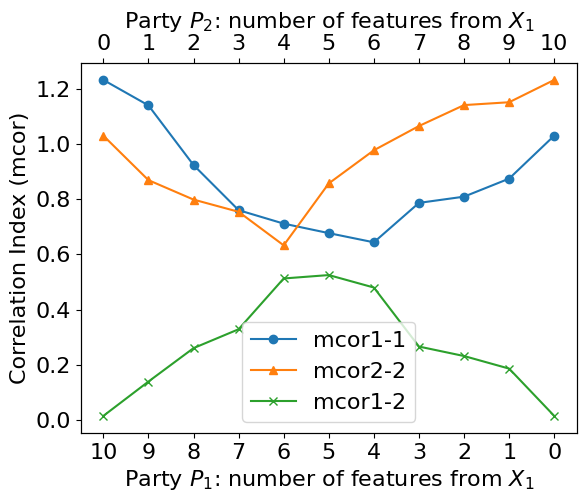

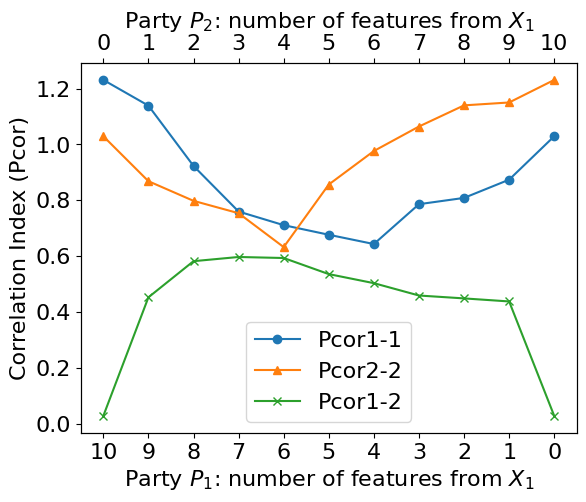

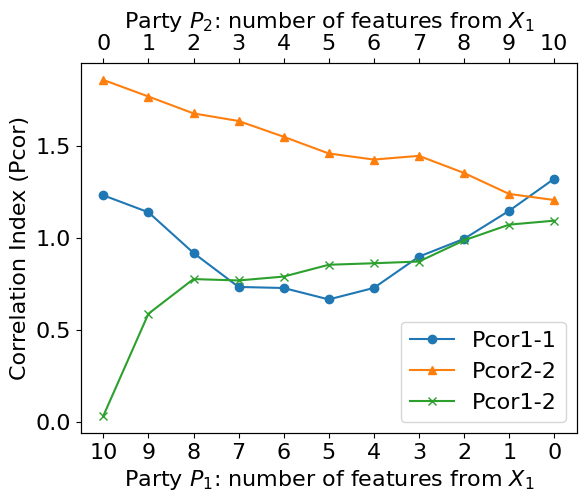

In [4]:
# test two functions
test_correlation_by_moving_features(n_informative=6, n_features1=10, n_features2=10, pcor_func=pcor_eigen,
                                    save_path="fig/pcor-eigen-10-10.png", label='mcor')
test_correlation_by_moving_features(n_informative=6, n_features1=10, n_features2=10, pcor_func=pcor_singular,
                                    save_path="fig/pcor-singular-10-10.png")
test_correlation_by_moving_features(n_informative=6, n_features1=10, n_features2=20, pcor_func=pcor_singular,
                                    save_path="fig/pcor-singular-10-20.png")

In [5]:
# generate three independent datasets
X1 = make_classification(n_samples=10000, n_features=10, n_informative=3, n_redundant=7, random_state=0, shuffle=True)[0]
X2 = make_classification(n_samples=10000, n_features=10, n_informative=3, n_redundant=7, random_state=1, shuffle=True)[0]
X3 = make_classification(n_samples=10000, n_features=10, n_informative=3, n_redundant=7, random_state=2, shuffle=True)[0]

# concatenate them to a global dataset
X = np.concatenate([X1, X2, X3], axis=1)
np.random.shuffle(X.T)

# original three parties
corr_evaluator_original = CorrelationEvaluator(gpu_id=0)
score_original = corr_evaluator_original.fit_evaluate([X1, X2, X3])
corr_evaluator_original.visualize("fig/pcor-original.png", value=score_original)

# fit the correlation splitter to get the lowest and highest correlation scores
corr_splitter = CorrelationSplitter(num_parties=3, evaluator=CorrelationEvaluator(gpu_id=0), gpu_id=0)
corr_splitter.fit(X, n_elites=200, n_offsprings=700, n_mutants=100, verbose=True)


CorrelationEvaluator uses cuda:0
Correlation calculation time: 0.05s


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


CorrelationEvaluator uses cuda:0
Calculating the min mcor of the overall correlation score...
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |     1000 |  0.8104289440 |  0.7328437169
     2 |     1800 |  0.8022293580 |  0.7200157146
     3 |     2600 |  0.7978345686 |  0.7133499881
     4 |     3400 |  0.7957684430 |  0.7133499881
     5 |     4200 |  0.7941030789 |  0.7133499881
     6 |     5000 |  0.7920218871 |  0.7061572671
     7 |     5800 |  0.7904692266 |  0.6923565467
     8 |     6600 |  0.7876569708 |  0.6790221433
     9 |     7400 |  0.7880947630 |  0.6790221433
    10 |     8200 |  0.7876258538 |  0.6736696561
    11 |     9000 |  0.7843035757 |  0.6559526225
    12 |     9800 |  0.7807071704 |  0.6559526225
    13 |    10600 |  0.7812397160 |  0.5952950219
    14 |    11400 |  0.7804148706 |  0.5952950219
    15 |    12200 |  0.7780725940 |  0.5599209964
    16 |    13000 |  0.7777865203 |  0.5599209964
    17 |    13800 |  0.7758149835 |  0.5599209964
    18

In [6]:
# split the correlation matrix with different beta
Xs_00 = corr_splitter.split(X, beta=0.0, n_elites=200, n_offsprings=700, n_mutants=100, verbose=True)
corr_evaluator_00 = CorrelationEvaluator(gpu_id=0)
score_00 = corr_evaluator_00.fit_evaluate(Xs_00)
corr_evaluator_00.visualize("fig/pcor-split-beta0.0.png", value=score_00, fontsize=28)

Xs_05 = corr_splitter.split(X, beta=0.5, n_elites=200, n_offsprings=700, n_mutants=100, verbose=True)
corr_evaluator_05 = CorrelationEvaluator(gpu_id=0)
score_05 = corr_evaluator_05.fit_evaluate(Xs_05)
corr_evaluator_05.visualize("fig/pcor-split-beta0.5.png", value=score_05, fontsize=28)

X_10 = corr_splitter.split(X, beta=1.0, n_elites=200, n_offsprings=700, n_mutants=100, verbose=True)
corr_evaluator_10 = CorrelationEvaluator(gpu_id=0)
score_10 = corr_evaluator_10.fit_evaluate(X_10)
corr_evaluator_10.visualize("fig/pcor-split-beta1.0.png", value=score_10, fontsize=28)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |     1000 |  0.7766456655 |  0.6723997630
     2 |     1800 |  0.7680928913 |  0.6716918486
     3 |     2600 |  0.7650321930 |  0.6716918486
     4 |     3400 |  0.7610694405 |  0.6716918486
     5 |     4200 |  0.7586840272 |  0.6287452914
     6 |     5000 |  0.7585722309 |  0.6137529400
     7 |     5800 |  0.7579175520 |  0.6137529400
     8 |     6600 |  0.7560351903 |  0.6137529400
     9 |     7400 |  0.7538671395 |  0.6137529400
    10 |     8200 |  0.7528442494 |  0.6137529400
    11 |     9000 |  0.7503268458 |  0.6137529400
    12 |     9800 |  0.7488579902 |  0.5616341569
    13 |    10600 |  0.7456918788 |  0.5616341569
    14 |    11400 |  0.7430248684 |  0.5616341569
    15 |    12200 |  0.7413260903 |  0.5616341569
    16 |    13000 |  0.7384359281 |  0.5616341569
    17 |    13800 |  0.7372806933 |  0.5418537793
    18 |    14600 |  0.7334038785 |  0.5418537793
    19 |    15400 |  0.7332785914 |  0.5418537793


In [7]:
# correlation score of randomly shuffled the features
X_shuffle = X.copy()
np.random.shuffle(X_shuffle.T)
Xs_shuffle = np.split(X_shuffle, 3, axis=1)
corr_evaluator_shuffle = CorrelationEvaluator(gpu_id=0)
score_shuffle = corr_evaluator_shuffle.fit_evaluate(Xs_shuffle)
corr_evaluator_shuffle.visualize("fig/pcor-shuffle.png", value=score_shuffle, fontsize=28)

CorrelationEvaluator uses cuda:0
Correlation calculation time: 0.03s


# Start evaluating real datasets

In [8]:
# Load Wide dataset
image_path = "data/real/nus-wide/uncompressed/images"
tag_path = "data/real/nus-wide/uncompressed/tags"
label_path = "data/real/nus-wide/uncompressed/labels"

train_test_wide_dataset = WideDataset.from_source(image_path, tag_path, label_path)
train_wide_dataset = train_test_wide_dataset.train
test_wide_dataset = train_test_wide_dataset.test
wide_Xs = []
for dataset in train_wide_dataset.local_datasets:
    print(dataset.X.shape)
    wide_Xs.append(dataset.X)

Loading CH...
Loading CORR...
Loading EDH...
Loading WT...
Loading CM55...
Loading tags...
Loading labels...
(161789, 65)
(161789, 145)
(161789, 74)
(161789, 129)
(161789, 226)
(161789, 1001)


In [9]:
# Load Vehicle dataset
vehicle_X, vehicle_y = load_svmlight_file("data/real/vehicle/processed/vehicle.libsvm")
vehicle_X = vehicle_X.toarray()
vehicle_y = vehicle_y.astype('int') - 1
vehicle_Xs = [vehicle_X[:, :50], vehicle_X[:, 50:]]

print(vehicle_Xs[0].shape)
print(vehicle_Xs[1].shape)

(78823, 50)
(78823, 50)


In [10]:
# Load satellite dataset
satellite_data = SatelliteDataset.from_pickle("data/real/satellite/cache/", n_jobs=8)
satellite_Xs = []
for dataset in satellite_data.local_datasets:
    satellite_Xs.append(dataset.X)
print(f"Size of Xs: {[X.shape for X in satellite_Xs]}")

# random sample some features for evaluation
satellite_n_features = 100
print(f"Random sample {satellite_n_features} features for evaluation")
satellite_Xs_sample_flatten = []
for X in satellite_Xs:
    X_flatten = X.reshape(X.shape[0], -1)
    X_sample = X_flatten[:, np.random.permutation(X_flatten.shape[1])[:satellite_n_features]]
    satellite_Xs_sample_flatten.append(X_sample)
print(f"Size of Xs: {[X.shape for X in satellite_Xs_sample_flatten]}")

100%|█████████████████████████████████████████████████████████████████| 16/16 [00:52<00:00,  3.30s/it]


Size of Xs: [torch.Size([3142, 13, 158, 158]), torch.Size([3142, 13, 158, 158]), torch.Size([3142, 13, 158, 158]), torch.Size([3142, 13, 158, 158]), torch.Size([3142, 13, 158, 158]), torch.Size([3142, 13, 158, 158]), torch.Size([3142, 13, 158, 158]), torch.Size([3142, 13, 158, 158]), torch.Size([3142, 13, 158, 158]), torch.Size([3142, 13, 158, 158]), torch.Size([3142, 13, 158, 158]), torch.Size([3142, 13, 158, 158]), torch.Size([3142, 13, 158, 158]), torch.Size([3142, 13, 158, 158]), torch.Size([3142, 13, 158, 158]), torch.Size([3142, 13, 158, 158])]
Random sample 100 features for evaluation
Size of Xs: [torch.Size([3142, 100]), torch.Size([3142, 100]), torch.Size([3142, 100]), torch.Size([3142, 100]), torch.Size([3142, 100]), torch.Size([3142, 100]), torch.Size([3142, 100]), torch.Size([3142, 100]), torch.Size([3142, 100]), torch.Size([3142, 100]), torch.Size([3142, 100]), torch.Size([3142, 100]), torch.Size([3142, 100]), torch.Size([3142, 100]), torch.Size([3142, 100]), torch.Size([3

In [11]:
# evaluate Icor for wide dataset
corr_evaluator_wide = CorrelationEvaluator(gpu_id=0)
wide_Xs = wide_Xs[:5]   # remove the tag features
icor_wide = corr_evaluator_wide.fit_evaluate(wide_Xs)
corr_evaluator_wide.visualize("fig/pcor-wide.png", value=icor_wide, fontsize=24)
print(f"icor for wide dataset: {icor_wide}")

# evaluate beta for wide dataset
wide_X = np.concatenate(wide_Xs, axis=1)
corr_splitter_wide = CorrelationSplitter(num_parties=5, evaluator=corr_evaluator_wide, gpu_id=0)
corr_splitter_wide.fit(wide_X, n_elites=200, n_offsprings=700, n_mutants=100, n_gen=100, verbose=True)
beta_wide = corr_splitter_wide.evaluate_beta(icor_wide)

print(f"beta for wide dataset: {beta_wide}, Icor: {icor_wide} in range [{corr_splitter_wide.min_mcor}, {corr_splitter_wide.max_mcor}]")

CorrelationEvaluator uses cuda:0
Correlation calculation time: 11.09s


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


icor for wide dataset: 1.6242226600646972
Calculating the min mcor of the overall correlation score...
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |     1000 |  2.3939884438 |  2.3794405460
     2 |     1800 |  2.3923500440 |  2.3764589310
     3 |     2600 |  2.3910715076 |  2.3742449284
     4 |     3400 |  2.3899349037 |  2.3711746454
     5 |     4200 |  2.3890318503 |  2.3703636885
     6 |     5000 |  2.3878238155 |  2.3653922796
     7 |     5800 |  2.3869677474 |  2.3649652481
     8 |     6600 |  2.3856544503 |  2.3649652481
     9 |     7400 |  2.3843540167 |  2.3574940920
    10 |     8200 |  2.3831895786 |  2.3574940920
    11 |     9000 |  2.3818654428 |  2.3543610096
    12 |     9800 |  2.3803591699 |  2.3529819965
    13 |    10600 |  2.3786754680 |  2.3521778345
    14 |    11400 |  2.3767532335 |  2.3475413084
    15 |    12200 |  2.3742549984 |  2.3410173893
    16 |    13000 |  2.3716930674 |  2.3410173893
    17 |    13800 |  2.3695291308 |  2.32925553

The score 1.6242226600646972 is out of range [1.8502450346946717, 2.4032484769821165].


In [12]:
# evaluate Icor for vehicle dataset
corr_evaluator_vehicle = CorrelationEvaluator(gpu_id=0)
icor_vehicle = corr_evaluator_vehicle.fit_evaluate(vehicle_Xs)
corr_evaluator_vehicle.visualize("fig/pcor-vehicle.png", value=icor_vehicle, fontsize=28)
print(f"icor for vehicle dataset: {icor_vehicle}")

# evaluate beta for vehicle dataset
vehicle_X = np.concatenate(vehicle_Xs, axis=1)
corr_splitter_vehicle = CorrelationSplitter(num_parties=2, evaluator=corr_evaluator_vehicle, gpu_id=0)
corr_splitter_vehicle.fit(vehicle_X, n_elites=200, n_offsprings=700, n_mutants=100, n_gen=50, verbose=True)
beta_vehicle = corr_splitter_vehicle.evaluate_beta(icor_vehicle)

print(f"beta for vehicle dataset: {beta_vehicle}, Icor: {icor_vehicle} in range [{corr_splitter_vehicle.min_mcor}, {corr_splitter_vehicle.max_mcor}]")

CorrelationEvaluator uses cuda:0
Correlation calculation time: 0.80s
icor for vehicle dataset: 0.3144468069076538
Calculating the min mcor of the overall correlation score...
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |     1000 |  1.9512892734 |  1.7858572006
     2 |     1800 |  1.9371093125 |  1.7792910337
     3 |     2600 |  1.9249953378 |  1.6808210611
     4 |     3400 |  1.9143945885 |  1.4862257242
     5 |     4200 |  1.9012671397 |  1.4862257242
     6 |     5000 |  1.8923217655 |  1.4743508101
     7 |     5800 |  1.8814250718 |  1.4743508101
     8 |     6600 |  1.8700459145 |  1.4743508101
     9 |     7400 |  1.8544078469 |  1.4733378887
    10 |     8200 |  1.8440072876 |  1.4688658714
    11 |     9000 |  1.8226668962 |  1.4688658714
    12 |     9800 |  1.7935215454 |  1.4418187141
    13 |    10600 |  1.7582443624 |  1.0200867653
    14 |    11400 |  1.7214027532 |  1.0200867653
    15 |    12200 |  1.6782221454 |  1.0200867653
    16 |    13000 |  1.62

In [13]:
# evaluate Icor for satellite dataset and plot
n_satellite_features = 10
satellite_Xs_sample_flatten_less_features = [X[:, :n_satellite_features] for X in satellite_Xs_sample_flatten]

corr_evaluator_satellite = CorrelationEvaluator(gpu_id=0)
icor_satellite = corr_evaluator_satellite.fit_evaluate(satellite_Xs_sample_flatten_less_features)
corr_evaluator_satellite.visualize("fig/pcor-satellite.png", value=icor_satellite, fontsize=16, title_size=28)
print(f"icor for satellite dataset: {icor_satellite}")

CorrelationEvaluator uses cuda:0
Correlation calculation time: 0.06s
icor for satellite dataset: 0.9042341247200966


In [14]:
# evaluate beta for satellite dataset
satellite_X = np.concatenate(satellite_Xs_sample_flatten_less_features, axis=1)
corr_splitter_satellite = CorrelationSplitter(num_parties=16, evaluator=corr_evaluator_satellite, gpu_id=0)
corr_splitter_satellite.fit(satellite_X, n_elites=200, n_offsprings=700, n_mutants=100, n_gen=50, verbose=True)

Calculating the min mcor of the overall correlation score...
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |     1000 |  0.9311424915 |  0.9266369676
     2 |     1800 |  0.9305525339 |  0.9266369676
     3 |     2600 |  0.9302761849 |  0.9263638183
     4 |     3400 |  0.9301181335 |  0.9263638183
     5 |     4200 |  0.9300189396 |  0.9263638183
     6 |     5000 |  0.9298918364 |  0.9262077808
     7 |     5800 |  0.9299551786 |  0.9261889656
     8 |     6600 |  0.9298999127 |  0.9259845500
     9 |     7400 |  0.9298062076 |  0.9257687653
    10 |     8200 |  0.9298024790 |  0.9255659377
    11 |     9000 |  0.9297222763 |  0.9255659377
    12 |     9800 |  0.9296931049 |  0.9255659377
    13 |    10600 |  0.9296286722 |  0.9255659377
    14 |    11400 |  0.9295596784 |  0.9255659377
    15 |    12200 |  0.9295475032 |  0.9252497022
    16 |    13000 |  0.9295388343 |  0.9242563193
    17 |    13800 |  0.9295069684 |  0.9242563193
    18 |    14600 |  0.9294904763 |  0.

In [15]:
beta_satellite = corr_splitter_satellite.evaluate_beta(icor_satellite)
print(f"beta for satellite dataset: {beta_satellite}, Icor: {icor_satellite} in range [{corr_splitter_satellite.min_mcor}, {corr_splitter_satellite.max_mcor}]")

beta for satellite dataset: -1.2892906879491686, Icor: 0.9042341247200966 in range [0.923851744333903, 0.9390675678849221]


The score 0.9042341247200966 is out of range [0.923851744333903, 0.9390675678849221].


# In the following, we will evaluate the importance $\alpha$ of each dataset

In [23]:
# train a model for wide dataset to evaluate Shapley value
wide_model = XGBClassifier(n_estimators=50, max_depth=6, n_jobs=16, learning_rate=0.1, objective="binary:logistic", tree_method="gpu_hist")
wide_model.fit(wide_X, train_wide_dataset.local_datasets[0].y, verbose=True)

# evaluate importance of wide dataset
imp_evaluator_wide = ImportanceEvaluator(sample_rate=0.01)
imp_wide_scores = imp_evaluator_wide.evaluate(wide_Xs, wide_model.predict, max_evals=1500)
print(f"Importance of wide dataset: {imp_wide_scores}")

Permutation explainer: 1618it [14:20,  1.75it/s]                                                      

Importance of wide dataset: [0.05762832 0.15752938 0.12381262 0.12163265 0.41572975]


In [24]:
# estimate the alpha of wide dataset
wide_dir_ratio = imp_wide_scores / np.sum(imp_wide_scores)
wide_alpha = corr_splitter_wide.evaluate_alpha(wide_dir_ratio)
print(f"alpha of wide dataset: {wide_alpha}")

alpha of wide dataset: 1.385463580447053


In [25]:
# train a model for vehicle dataset to evaluate Shapley value
vehicle_model = XGBClassifier(n_estimators=50, max_depth=6, n_jobs=16, learning_rate=0.1, objective="multi:softmax", tree_method="gpu_hist")
vehicle_model.fit(vehicle_X, vehicle_y, verbose=True)

# evaluate importance of vehicle dataset
imp_evaluator_vehicle = ImportanceEvaluator(sample_rate=0.001)
imp_vehicle_scores = imp_evaluator_vehicle.evaluate(vehicle_Xs, vehicle_model.predict, max_evals=1500)
print(f"Importance of vehicle dataset: {imp_vehicle_scores}")


Importance of vehicle dataset: [0.45496337 0.71888278]


In [26]:
# estimate the alpha of vehicle dataset
vehicle_alpha = corr_splitter_vehicle.evaluate_alpha(imp_vehicle_scores)
print(f"alpha of vehicle dataset: {vehicle_alpha}")


alpha of vehicle dataset: 9.391216110332813


In [41]:
# train a model for satellite dataset to evaluate Shapley value
satellite_model = XGBClassifier(n_estimators=50, max_depth=6, n_jobs=16, learning_rate=0.1, objective="multi:softmax", tree_method="gpu_hist")
satellite_X_train = np.concatenate(satellite_Xs_sample_flatten_less_features, axis=1)
satellite_y_train = satellite_data.local_datasets[0].y
satellite_model.fit(satellite_X_train, satellite_y_train, verbose=True)

# evaluate importance of satellite dataset
imp_evaluator_satellite = ImportanceEvaluator(sample_rate=0.01)
imp_satellite_scores = imp_evaluator_satellite.evaluate(satellite_Xs_sample_flatten_less_features, satellite_model.predict, max_evals=3500)
print(f"Importance of satellite dataset: {imp_satellite_scores}")

Permutation explainer: 32it [00:13,  2.44it/s]                                                        

Importance of satellite dataset: [0.10845161 0.06051613 0.02616129 0.03074194 0.05880645 0.06243548
 0.02719355 0.04640323 0.04346774 0.02482258 0.02920968 0.06987097
 0.05754839 0.05372581 0.05729032 0.04506452]


In [42]:
# estimate the alpha of satellite dataset
satellite_alpha = corr_splitter_satellite.evaluate_alpha(imp_satellite_scores)
print(f"alpha of satellite dataset: {satellite_alpha}")

alpha of satellite dataset: 5.4086567124637615


# Plot the distribution of $\alpha$ and $\beta$ of each dataset

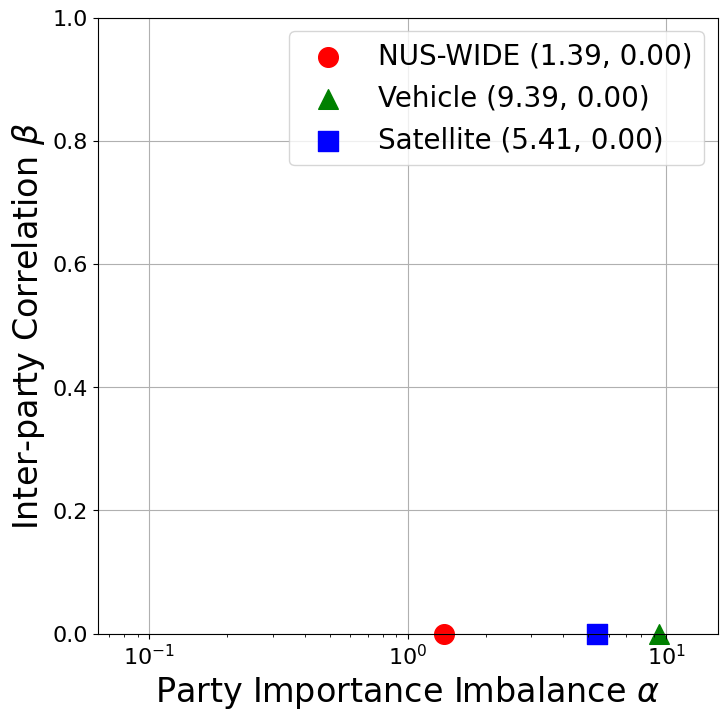

In [43]:
# plot the distribution of alpha and beta in one image, one dimension is importance-alpha, the other is correlation-beta
# each dataset is a point in plot
def round_in_range(x, min_x=0., max_x=1.):
    if x < min_x:
        return min_x
    elif x > max_x:
        return max_x
    else:
        return x

wide_beta_round = round_in_range(beta_wide)
vehicle_beta_round = round_in_range(beta_vehicle)
satellite_beta_round = round_in_range(beta_satellite)

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(wide_alpha, wide_beta_round, c="r", marker="o", label=rf"NUS-WIDE ({wide_alpha:.2f}, {wide_beta_round:.2f})",
           s=200, clip_on=False)
ax.scatter(vehicle_alpha, vehicle_beta_round, c="g", marker="^", label=rf"Vehicle ({vehicle_alpha:.2f}, {vehicle_beta_round:.2f})",
           s=200, clip_on=False)
ax.scatter(satellite_alpha, satellite_beta_round, c="b", marker="s", label=rf"Satellite ({satellite_alpha:.2f}, {satellite_beta_round:.2f})",
           s=200, clip_on=False)
ax.set_xlabel(r"Party Importance Imbalance $\alpha$", fontsize=24)
ax.set_ylabel(r"Inter-party Correlation $\beta$", fontsize=24)
ax.set_xlim([10**-1.2, 10**1.2])
ax.set_ylim([0, 1])
# set xaxis as log scale
ax.set_xscale("log")
ax.legend(fontsize=20)
ax.grid(True)
plt.show()


In [31]:
# evaluate Icor for shuffled wide dataset
wide_shuffle_indices = np.random.permutation(wide_X.shape[1])
wide_X_shuffle = wide_X[:, wide_shuffle_indices]
wide_feature_cut_points = np.cumsum([X.shape[1] for X in wide_Xs])
wide_Xs_shuffle = np.split(wide_X_shuffle, wide_feature_cut_points, axis=1)[:-1]

assert np.all([X1.shape == X2.shape for X1, X2 in zip(wide_Xs, wide_Xs_shuffle)])

corr_evaluator_shuffle_wide = CorrelationEvaluator(gpu_id=0)
icor_shuffle_wide = corr_evaluator_shuffle_wide.fit_evaluate(wide_Xs_shuffle)
print(f"icor for shuffled wide dataset: {icor_shuffle_wide}")

# evaluate beta for shuffled wide dataset (no need to refit splitter since features are not changed)
beta_shuffle_wide = corr_splitter_wide.evaluate_beta(icor_shuffle_wide)
print(f"beta for shuffled wide dataset: {beta_shuffle_wide}")

CorrelationEvaluator uses cuda:0
Correlation calculation time: 9.91s
icor for shuffled wide dataset: 2.6337899684906008


The score 2.6337899684906008 is out of range [1.8502450346946717, 2.4032484769821165].


In [34]:
# evaluate Icor for shuffled vehicle dataset
vehicle_shuffle_indices = np.random.permutation(vehicle_X.shape[1])
vehicle_X_shuffle = vehicle_X[:, vehicle_shuffle_indices]
vehicle_feature_cut_points = np.cumsum([X.shape[1] for X in vehicle_Xs])
vehicle_Xs_shuffle = np.split(vehicle_X_shuffle, vehicle_feature_cut_points, axis=1)[:-1]

assert np.all([X1.shape == X2.shape for X1, X2 in zip(vehicle_Xs, vehicle_Xs_shuffle)])

corr_evaluator_shuffle_vehicle = CorrelationEvaluator(gpu_id=0)
icor_shuffle_vehicle = corr_evaluator_shuffle_vehicle.fit_evaluate(vehicle_Xs_shuffle)
print(f"icor for shuffled vehicle dataset: {icor_shuffle_vehicle}")

# evaluate beta for shuffled vehicle dataset (no need to refit splitter since features are not changed)
beta_shuffle_vehicle = corr_splitter_vehicle.evaluate_beta(icor_shuffle_vehicle)
print(f"beta for shuffled vehicle dataset: {beta_shuffle_vehicle}")

CorrelationEvaluator uses cuda:0
Correlation calculation time: 0.77s
icor for shuffled vehicle dataset: 1.9585521221160889
beta for shuffled vehicle dataset: 0.9886110591172752


In [61]:
# evaluate Icor for shuffled satellite dataset
satellite_X_sample_flatten_less_features = np.concatenate(satellite_Xs_sample_flatten_less_features, axis=1)
satellite_shuffle_indices = np.random.permutation(satellite_X_sample_flatten_less_features.shape[1])
satellite_X_sample_flatten_shuffle = satellite_X_sample_flatten_less_features[:, satellite_shuffle_indices]
satellite_feature_cut_points = np.cumsum([X.shape[1] for X in satellite_Xs_sample_flatten_less_features])
satellite_Xs_sample_flatten_shuffle = np.split(satellite_X_sample_flatten_shuffle, satellite_feature_cut_points, axis=1)[:-1]

assert np.all([X1.shape == X2.shape for X1, X2 in zip(satellite_Xs_sample_flatten_less_features, satellite_Xs_sample_flatten_shuffle)])

corr_evaluator_shuffle_satellite = CorrelationEvaluator(gpu_id=0)
icor_shuffle_satellite = corr_evaluator_shuffle_satellite.fit_evaluate(satellite_Xs_sample_flatten_shuffle)
print(f"icor for shuffled satellite dataset: {icor_shuffle_satellite}")

# evaluate beta for shuffled satellite dataset (no need to refit splitter since features are not changed)
beta_shuffle_satellite = corr_splitter_satellite.evaluate_beta(icor_shuffle_satellite)
print(f"beta for shuffled satellite dataset: {beta_shuffle_satellite}")

CorrelationEvaluator uses cuda:0
Correlation calculation time: 0.05s
icor for shuffled satellite dataset: 0.9318517088890076
beta for shuffled satellite dataset: 0.5257661228970268


In [36]:
# evaluate importance for shuffled wide dataset
wide_shuffle_model = XGBClassifier(n_estimators=50, max_depth=6, n_jobs=16, learning_rate=0.1, objective="binary:logistic", tree_method="gpu_hist")
wide_shuffle_model.fit(wide_X_shuffle, train_wide_dataset.local_datasets[0].y, verbose=True)

# evaluate importance of wide dataset
imp_evaluator_wide_shuffle = ImportanceEvaluator(sample_rate=0.01)
imp_shuffle_wide_scores = imp_evaluator_wide.evaluate(wide_Xs_shuffle, wide_shuffle_model.predict, max_evals=1500)
print(f"Importance of wide dataset: {imp_shuffle_wide_scores}")

Permutation explainer: 1618it [14:10,  2.05it/s]                                                      

Importance of wide dataset: [0.06111317 0.12992888 0.19327149 0.24715832 0.24019171]


In [37]:
# evaluate alpha for shuffled wide dataset
alpha_shuffle_wide = corr_splitter_wide.evaluate_alpha(imp_shuffle_wide_scores)
print(f"alpha for shuffled wide dataset: {alpha_shuffle_wide}")

alpha for shuffled wide dataset: 4.703892330307253


In [38]:
# evaluate importance for shuffled vehicle dataset
vehicle_shuffle_model = XGBClassifier(n_estimators=50, max_depth=6, n_jobs=16, learning_rate=0.1, objective="multi:softmax", tree_method="gpu_hist")
vehicle_shuffle_model.fit(vehicle_X_shuffle, vehicle_y, verbose=True)

# evaluate importance of vehicle dataset
imp_evaluator_vehicle_shuffle = ImportanceEvaluator(sample_rate=0.001)
imp_shuffle_vehicle_scores = imp_evaluator_vehicle_shuffle.evaluate(vehicle_Xs_shuffle, vehicle_shuffle_model.predict, max_evals=1500)
print(f"Importance of vehicle dataset: {imp_shuffle_vehicle_scores}")

Importance of vehicle dataset: [0.78004579 0.3949359 ]


In [39]:
# evaluate alpha for shuffled vehicle dataset
alpha_shuffle_vehicle = corr_splitter_vehicle.evaluate_alpha(imp_shuffle_vehicle_scores)
print(f"alpha for shuffled vehicle dataset: {alpha_shuffle_vehicle}")

alpha for shuffled vehicle dataset: 4.154390897214498


In [63]:
# evaluate importance for shuffled satellite dataset
satellite_shuffle_model = XGBClassifier(n_estimators=50, max_depth=6, n_jobs=16, learning_rate=0.1, objective="multi:softmax", tree_method="gpu_hist")
satellite_X_train_shuffle = satellite_X_train[:, satellite_shuffle_indices]
satellite_shuffle_model.fit(satellite_X_train_shuffle, satellite_y_train, verbose=True)

# evaluate importance of satellite dataset
imp_evaluator_satellite_shuffle = ImportanceEvaluator(sample_rate=0.01)
imp_shuffle_satellite_scores = imp_evaluator_satellite_shuffle.evaluate(satellite_Xs_sample_flatten_shuffle, satellite_shuffle_model.predict, max_evals=1500)
print(f"Importance of satellite dataset: {imp_shuffle_satellite_scores}")

Importance of satellite dataset: [0.05818548 0.06072581 0.03955645 0.03653226 0.07689516 0.11483871
 0.05737903 0.04915323 0.03447581 0.04225806 0.04608871 0.0278629
 0.09899194 0.04495968 0.0496371  0.05391129]


In [65]:
# evaluate alpha for shuffled satellite dataset
alpha_shuffle_satellite = corr_splitter_satellite.evaluate_alpha(imp_shuffle_satellite_scores)
print(f"alpha for shuffled satellite dataset: {alpha_shuffle_satellite}")


alpha for shuffled satellite dataset: 5.630092966674526


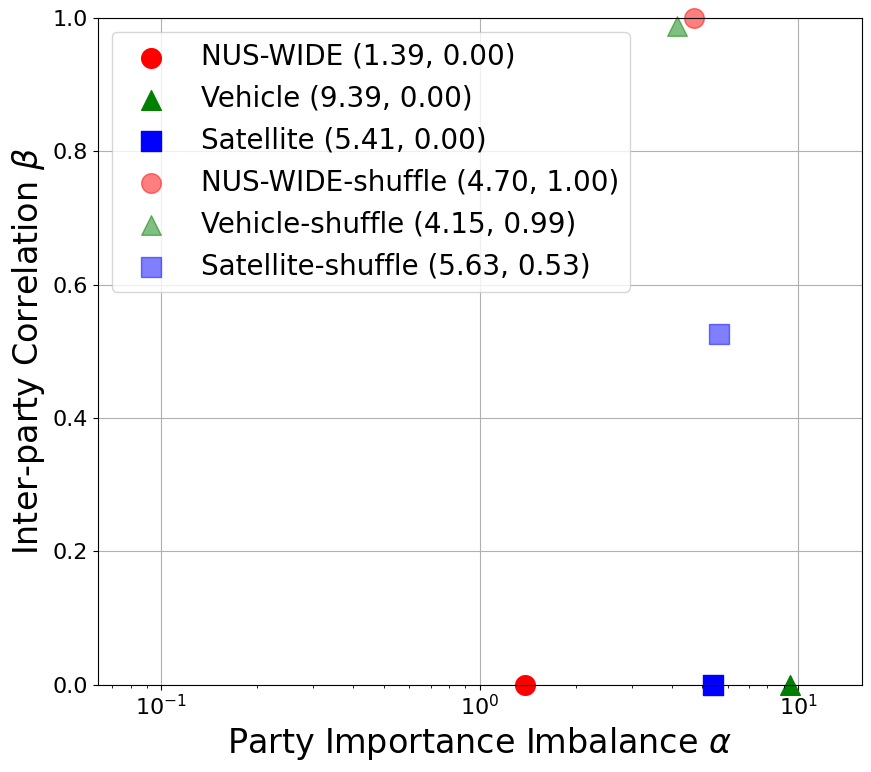

In [73]:

# plot the results of both original and shuffled
# plot the distribution of alpha and beta in one image, one dimension is importance-alpha, the other is correlation-beta
# each dataset is a point in plot
wide_beta_round = round_in_range(beta_wide)
vehicle_beta_round = round_in_range(beta_vehicle)
satellite_beta_round = round_in_range(beta_satellite)
wide_shuffle_beta_round = round_in_range(beta_shuffle_wide)
vehicle_shuffle_beta_round = round_in_range(beta_shuffle_vehicle)
satellite_shuffle_beta_round = round_in_range(beta_shuffle_satellite)

fig, ax = plt.subplots(figsize=(9, 8))

from matplotlib.patches import Rectangle
e = Rectangle((0, 0), 0, 0, 0)
e.set_clip_box(ax.bbox)
e.set_alpha(0.1)
e.set_color("grey")
e.set_label("Uncovered")
ax.add_artist(e)

e = Rectangle(xy=(1.2,0), width=100, height=0.15)
e.set_clip_box(ax.bbox)
e.set_alpha(0.08)
e.set_color("blue")
e.set_label("Real data")
ax.add_artist(e)

e = Rectangle(xy=(3, 0.5), width=100, height=0.7, color='red')
e.set_clip_box(ax.bbox)
e.set_alpha(0.08)
e.set_color("red")
e.set_label("Randomly split data")
ax.add_artist(e)

ax.scatter(wide_alpha, wide_beta_round, c="r", marker="o", label=rf"NUS-WIDE ({wide_alpha:.2f}, {wide_beta_round:.2f})",
           s=200, clip_on=False)
ax.scatter(vehicle_alpha, vehicle_beta_round, c="g", marker="^", label=rf"Vehicle ({vehicle_alpha:.2f}, {vehicle_beta_round:.2f})",
           s=200, clip_on=False)
ax.scatter(satellite_alpha, satellite_beta_round, c="b", marker="s", label=rf"Satellite ({satellite_alpha:.2f}, {satellite_beta_round:.2f})",
           s=200, clip_on=False)
ax.scatter(alpha_shuffle_wide, wide_shuffle_beta_round, marker="o", label=rf"NUS-WIDE-shuffle ({alpha_shuffle_wide:.2f}, {wide_shuffle_beta_round:.2f})",
s=200, clip_on=False, alpha=0.5, hatch="/////", color='none', edgecolor='red')
ax.scatter(alpha_shuffle_vehicle, vehicle_shuffle_beta_round, marker="^", label=rf"Vehicle-shuffle ({alpha_shuffle_vehicle:.2f}, {vehicle_shuffle_beta_round:.2f})",
s=200, clip_on=False, alpha=0.5, hatch="...", color='none', edgecolor='green')
ax.scatter(alpha_shuffle_satellite, satellite_shuffle_beta_round, marker="s", label=rf"Satellite-shuffle ({alpha_shuffle_satellite:.2f}, {satellite_shuffle_beta_round:.2f})",
s=200, clip_on=False, alpha=0.5, hatch=r"\\\\", color='none', edgecolor='blue')

ax.set_xlabel(r"Party Importance Imbalance $\alpha$", fontsize=24)
ax.set_ylabel(r"Inter-party Correlation $\beta$", fontsize=24)
ax.set_xlim([10**-1.2, 10**1.2])
ax.set_ylim([0, 1])
# set xaxis as log scale
ax.set_xscale("log")
ax.legend(fontsize=20, loc="upper left")
ax.grid(True)
ax.set_facecolor('#f2f2f2')
plt.tight_layout()
plt.savefig("fig/data-dist-full.png")
plt.show()